# High Performance Computing - Coursework (Python Implementation)
##### Raihaan Usman - AE3

> The objective of this coursework assignment is to write a parallel numerical code to solve a 2D reaction-diffusion problem, paying particular attention to computational performance. These types of partial differential equations (PDE) appear in many areas of science including predator-prey scenarios, models of biological systems, excitable media and chemical reactions, etc. They can be quite computationally expensive to solve if the model is stiff (i.e. there are phenomena covering a wide range of timescales), so performance optimisation and parallelisation are important.

The brief sure sounds fun - let's get started!

(P.S. - I'm using Python to prototype the code so I know I've implemented it correctly. I'm not a Python expert, so please don't judge me :)

## 1. Problem Definition

In [1]:
# Mandatory imports :)

import numpy as np
import scipy as sp
import multiprocessing as mp
from matplotlib import pyplot as plt
from numpy.linalg import matrix_power

The system of PDEs in question are apparently a variant of the Barkley model and are given by-

\begin{aligned}
&\frac{\partial u}{\partial t}-\mu_{1} \nabla^{2} u=f_{1}(u, v) \\\\
&\frac{\partial v}{\partial t}-\mu_{2} \nabla^{2} v=f_{2}(u, v)
\end{aligned}

where $u_1$ and $u_2$ are coefficients of diffusion, $\mu_{1}$ and $\mu_{2}$ are the reaction rates, and $f_{1}$ and $f_{2}$ are the reaction terms-

\begin{aligned}
&f_{1}(u, v)=\epsilon u(1-u)\left(u-\frac{(v+b)}{a}\right) \\
&f_{2}(u, v)=u^{3}-v
\end{aligned}

In [2]:
# Defining the reaction functions
def _f1(u, v, epsilon, a, b):
    return epsilon * u * (1-u) * (u - (v+b)/a)

def _f2(u, v):
    return u**3 - v

The specific PDE parameters are $\mu_1, \mu_2, a, b, \epsilon$ and the initial conditions are $u_1(x, y)$ and $u_2(x, y)$. 

To solve this problem, we're asked to implement forward Euler time marching. So additionally, spatial and temporal discretisation are required - therefore $dx$, $dy$ ($h^2 = dx \cdot dy$) and $dt$ need to be defined, along with $N_x$, $N_y$ and $T$ - the number of discrete nodes in x and y, and the total integration time-

In [3]:
# Defaults for the system - select based on test case 1 - 4
def setParameters(test_case=1):
    a       = [0.75, 0.75, 0.5, 0.75]
    b       = [0.06, 0.06, 0.1, 0.0001]
    mu1     = [5.0, 5.0, 5.0, 1.0]
    mu2     = [0.0, 0.0, 0.0, 0.01]
    epsilon = [50.0, 13.0, 50.0, 12.5]

    # Discretization parameters
    Nx      = [101, 251, 101, 151]
    Ny      = [101, 251, 101, 81]
    dx      = 1
    dy      = 1
    dt      = 0.001
    t       = 100

    # Reset parameters based on test case
    a, b, mu1, mu2, epsilon, Nx, Ny = [i[test_case-1] for i in [a, b, mu1, mu2, epsilon, Nx, Ny]]

    # Initialise the X, Y and T discrete arrays
    X = np.arange(0, Nx, dx)
    Y = np.arange(0, Ny, dy)
    T = np.arange(0, t+dt, dt)

    print(f"\n\
    X = \n{X} --> Shape = {X.shape}, \n\n\
    Y = \n{Y} --> Shape = {Y.shape}, \n\n\
    T = \n{T} --> Shape = {T.shape}")

    return a, b, mu1, mu2, epsilon, Nx, Ny, dx, dy, dt, t, X, Y, T

## 2. Initial Conditions

Initial conditions are simple enough - for $y > L_y/2 \rightarrow u = 1$ and 0 otherwise. For $x < L_x/2 \rightarrow v = a/2$ and 0 otherwise. 

Note that $L_x$ and $L_y$ are the lengths of the domain in the x and y directions - $N_x * dx$ and $N_y * dy$ respectively.

In [4]:
# Initialising U and V - in Python, we can use the np.where() function to query the x and y arrays
def setInitialConditions(X, Y, Nx, Ny, a, dx, dy):
    U = np.where(Y > Ny*dy/2, 1, 0).astype(np.float32)
    U = np.tile(U, (Nx, 1))

    # Note that the indicies correspond to the x and y coordinates and so the matrices are not correctly oriented - U needs a 90 degree rotation anticlockwise
    U = np.rot90(U, 1)

    V = np.where(X < Nx*dx/2, a/2, 0)
    V = np.tile(V, (Ny, 1))

    # Reality check
    print(f"\n\
    Initial U = \n{U} --> Shape = {U.shape} \n\n\
    Initial V = \n{V} --> Shape = {V.shape}")

    return U, V

## 3. Central Differencing

The temporal derivatives are computed by a first-order finite difference scheme, and the Laplacians over the cartesian space are computed using a second-order finite difference scheme.


\begin{aligned}
\frac{u_{i, j}^{n+1}-u_{i, j}^{n}}{\Delta t} &=\frac{\mu_{1}}{h^{2}}\left(u_{i+1, j}^{n}+u_{i-1, j}^{n}+u_{i, j+1}^{n}+u_{i, j-1}^{n}-4 u_{i, j}^{n}\right)+f_{1}\left(u_{i, j}^{n}, v_{i, j}^{n}\right) \\\\
\frac{v_{i, j}^{n+1}-v_{i, j}^{n}}{\Delta t} &=\frac{\mu_{2}}{h^{2}}\left(v_{i+1, j}^{n}+v_{i-1, j}^{n}+v_{i, j+1}^{n}+v_{i, j-1}^{n}-4 v_{i, j}^{n}\right)+f_{2}\left(u_{i, j}^{n}, v_{i, j}^{n}\right) .
\end{aligned}

Pre-multiplying by an identity matrix, for instance, returns an unshifted matrix - e.g $U_{i,j}$. If instead 1's are on the superdiagonal - an upper shift matrix - pre-multiplication with $U$ returns $U_{i+1,j}$. Similarly, if 1's are on the subdiagonal - a lower shift matrix - pre-multiplication with $U$ returns $U_{i-1,j}$.

To shift matrices left or right, i.e in the $j$ direction, the shift matrix can be post-multipied instead. These shifts are sufficient to design a square [$N_y,\ N_y$] shift matrix, A, to implement this central differencing scheme on the interior points of the mesh - note that in the case on a non-square mesh, a second square matrix B of size [$N_x,\ N_x$] is required for post-multiplication, but will have exactly the same form.

$$
A := \left[\begin{array}{ccccccc}0 & \cdots & \cdots & \cdots & \cdots & 0 \\1 & -2 & 1 & & & \vdots \\0 & \ddots & \ddots & \ddots & & \vdots \\\vdots & & \ddots & \ddots & \ddots & 0 \\ \vdots & & & 1 & -2 & 1 \\0 & \cdots & \cdots & \cdots & \cdots & 0\end{array}\right]
$$

Note the padded rows and columns - in this form, $AU^n$ or $U^nA$ only computes the $x$ and $y$ components of the Laplacian for the interior nodes of the mesh.

In [5]:
# Matrix A is a shift matrix which transforms U and V to compute the terms in the central finite difference scheme
def setMatrixA_interior(Ny):
    
    # A is a square matrix of size Ny x Ny ---> [Ny x Ny] (A) * [Ny x Nx] (U or V) = [Ny x Nx]
    A = np.eye(Ny)
    i,j = np.indices(A.shape)

    # Populate the diagonals of A
    A[i==j] = -2        # Main diagonal
    A[i==j-1] = 1       # Superdiagonal
    A[i==j+1] = 1       # Subdiagonal

    # Reset top and bottom rows of A to 0 - not dealing with the boundaries yet!
    A[0,:] = 0
    A[-1,:] = 0

    # Reality check
    # print(f"A = \n{A}")

    return A


def setMatrixB_interior(Nx):
    # Note that this function is only called if the mesh is not square - otherwise, the matrix B points to A

    B = np.eye(Nx)
    i,j = np.indices(B.shape)

    # Populate the diagonals of B
    B[i==j] = -2        # Main diagonal
    B[i==j-1] = 1       # Superdiagonal
    B[i==j+1] = 1       # Subdiagonal

    # Reset top and bottom rows of B to 0 - not dealing with the boundaries yet!
    B[0,:] = 0
    B[-1,:] = 0

    # Reality check
    # print(f"B = \n{B}")

    return B

## 4. Neumann Boundary Conditions

The shift matrix $A$ must be modified to include the boundaries. A Neumann boundary condition is applied to every boundary in $U$ and $V$ ($x=0, x=L_x, y=0, y=L_y$).

This means the normal derivatives of $U$ and $V$ are zero at the boundaries - e.g at $x = 0$, $\frac{\partial{U}}{\partial{x}}$ and $\frac{\partial{V}}{\partial{x}}$ are zero. In discrete form, this is given by-

$\begin{aligned}
\left(u_{1, j}^{n}-u_{-1, j}^{n}\right) / h = 0 ; \quad u_{-1, j}^{n} = u_{0, j}^{n}
\end{aligned}$

$\begin{aligned}
\therefore \frac{u_{0, j}^{n+1}-u_{0, j}^{n}}{\Delta t} = \frac{\mu_{1}}{h^{2}}\left(u_{1, j}^{n}+u_{0, j}^{n}+u_{0, j+1}^{n}+u_{0, j-1}^{n}-2 u_{0, j}^{n}\right)+f_{1}\left(u_{0, j}^{n}, v_{i, j}^{n}\right)
\end{aligned}$


The modified shift matrix is adjusted to account for the updated central difference scheme at the boundaries. Note that it is still a symmetric banded matrix-

$$
A := \left[\begin{array}{ccccccc}-1 & 1 & 0 & \cdots & \cdots & 0 \\1 & -2 & 1 & & & \vdots \\0 & \ddots & \ddots & \ddots & & \vdots \\\vdots & & \ddots & \ddots & \ddots & 0 \\ \vdots & & & 1 & -2 & 1 \\0 & \cdots & \cdots & 0 & 1 & -1\end{array}\right]
$$

In [6]:
def setMatrixA(Ny):

    # First set the interior matrix
    A = setMatrixA_interior(Ny)

    # Add the boundary conditions
    A[0,0] = -1
    A[0,1] = 1
    A[-1,-1] = -1
    A[-1,-2] = 1

    # Reality check
    # print(f"A = \n{A}")
    return A


def setMatrixB(Nx):
    # Note that this function is only called if the mesh is not square - otherwise, the matrix B points to A

    # First set the interior matrix
    B = setMatrixB_interior(Nx)

    # Add the boundary conditions
    B[0,0] = -1
    B[0,1] = 1
    B[-1,-1] = -1
    B[-1,-2] = 1

    # Reality check
    # print(f"B = \n{B}")
    return B

## 5. Time Integration

Finally, forward Euler time marching is implemented using a simple loop over the time steps-

$\begin{aligned}
u_{i,j}^{n+1} = u_{i,j}^{n} + \frac{u_{i, j}^{n+1}-u_{i, j}^{n}}{\Delta t} \cdot dt
\end{aligned}$

In [7]:
def time_march(U, V, A, dt, T, a, b, epsilon, mu1, mu2, rect=0):
    
    if rect != 0:   # If the mesh is not square, we need to set the matrix B - rect contains Nx
        
        B = setMatrixB(rect)
    
        # Loop through the time steps
        for _ in T:

            # Evaluate the reaction terms
            f1 = _f1(U, V, epsilon, a, b)
            f2 = _f2(U, V)

            # Perform the forward Euler step
            U += dt * (mu1 * (A.dot(U) + U.dot(B)) + f1)
            V += dt * (mu2 * (A.dot(V) + V.dot(B)) + f2)

    
    else:   # If the mesh is square, we can use the matrix A for both xx and yy Lapacian terms
       
        # Loop through the time steps
        for _ in T:

            # Evaluate the reaction terms
            f1 = _f1(U, V, epsilon, a, b)
            f2 = _f2(U, V)

            # Perform the forward Euler step
            U += dt * (mu1 * (A.dot(U) + U.dot(A)) + f1)
            V += dt * (mu2 * (A.dot(V) + V.dot(A)) + f2)

    return U, V

## Run Program!

In [15]:
# Program starts here! First set parameters...
test_case = 4
a, b, mu1, mu2, epsilon, Nx, Ny, dx, dy, dt, t, X, Y, T = setParameters(test_case)

# Set the initial conditions
U, V = setInitialConditions(X, Y, Nx, Ny, a, dx, dy)

# Build the shift matrix A
A = setMatrixA(Ny)

# Build the shift matrix B (if the mesh is not square)
if Nx == Ny:    rect = 0
else:           rect = Nx

# Final check on U, V, A, dt and T
print(f"\n\
U = \n{U} --> Shape = {U.shape}, \n\n\
V = \n{V} --> Shape = {V.shape}, \n\n\
A = \n{A} --> Shape = {A.shape}, \n\n\
Is B required? --> {rect != 0}, \n\n\
dt = \n{dt} \n\n\
T = \n{T} --> Shape = {T.shape}, \n\n\
a = \n{a}, \n\n\
b = \n{b} \n\n\
epsilon = \n{epsilon} \n\n\
mu1 = \n{mu1} \n\n\
mu2 = \n{mu2}")

# Iterate through time steps
U, V = time_march(U, V, A, dt, T, a, b, epsilon, mu1, mu2, rect)


    X = 
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150] --> Shape = (151,), 

    Y = 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80] --> Shape = (81,), 

    T = 
[0.0000e+00 1.0000e-03 2.0000e-03 ... 9.9998e+01 9.9999e+01 1.0000e

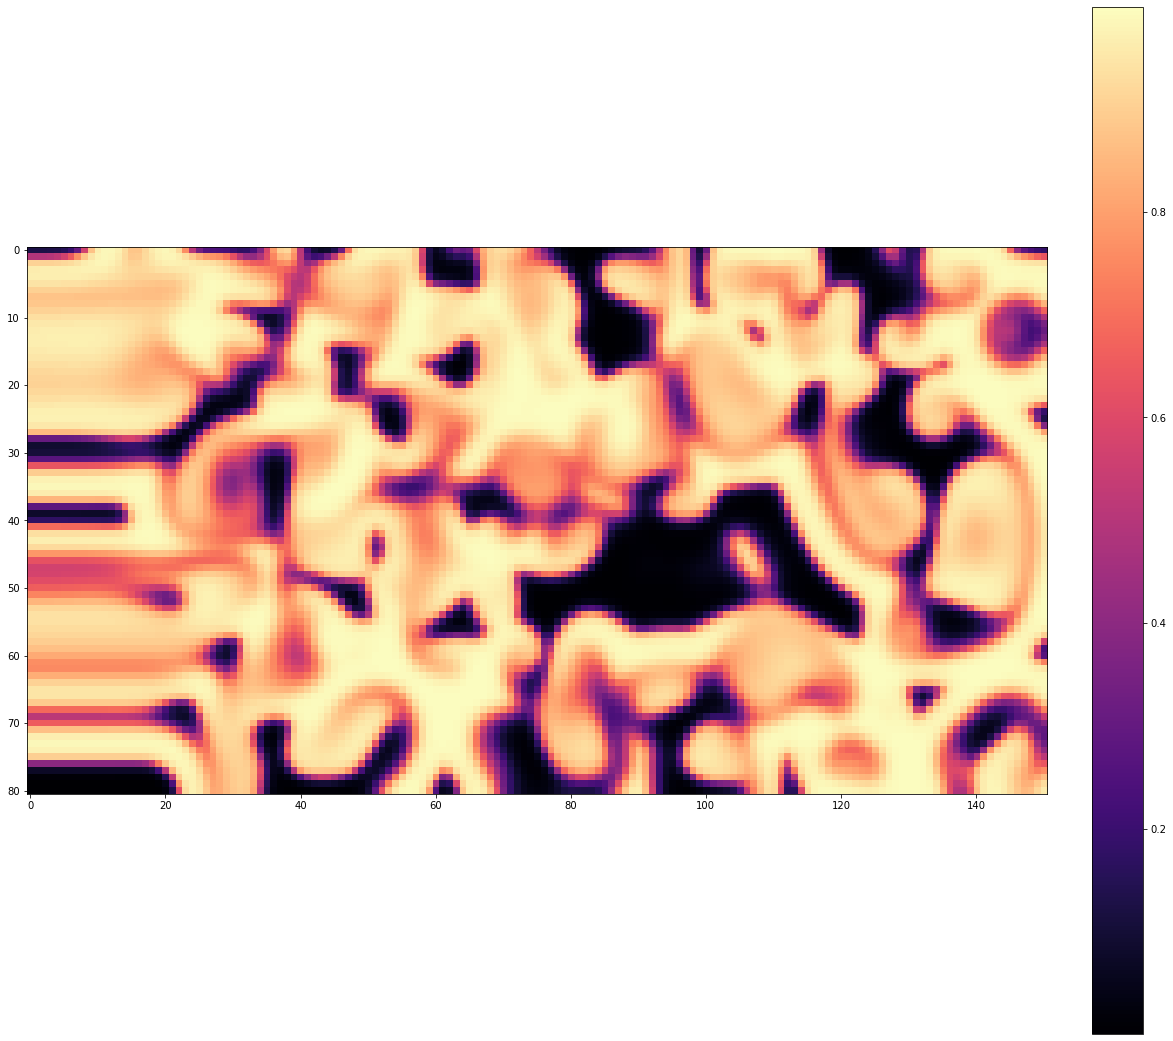

In [16]:
# Plot the final solution
plt.figure(figsize=(20,20))
plt.imshow(U, cmap='magma', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)

# Save the final solution to figs/final_solution.png
plt.savefig(f'figs/final_solution_test_{test_case}.png', dpi=300)
plt.show()

As you can see, the solution closely matches the solution presented in the brief - I am therefore confident that the implementation is correct and will proceed to converting this to parallelised C++ code!